In [23]:
import matplotlib.pyplot as plt
import json
from constants import step_to_revision
import os

In [24]:
# have a pandas table that is for every revision, it has its zero shot acc for tasks, quantization stuff, etc.
# with open('scaling.json', 'r') as file:
#     x = json.load(file)



### 1B results

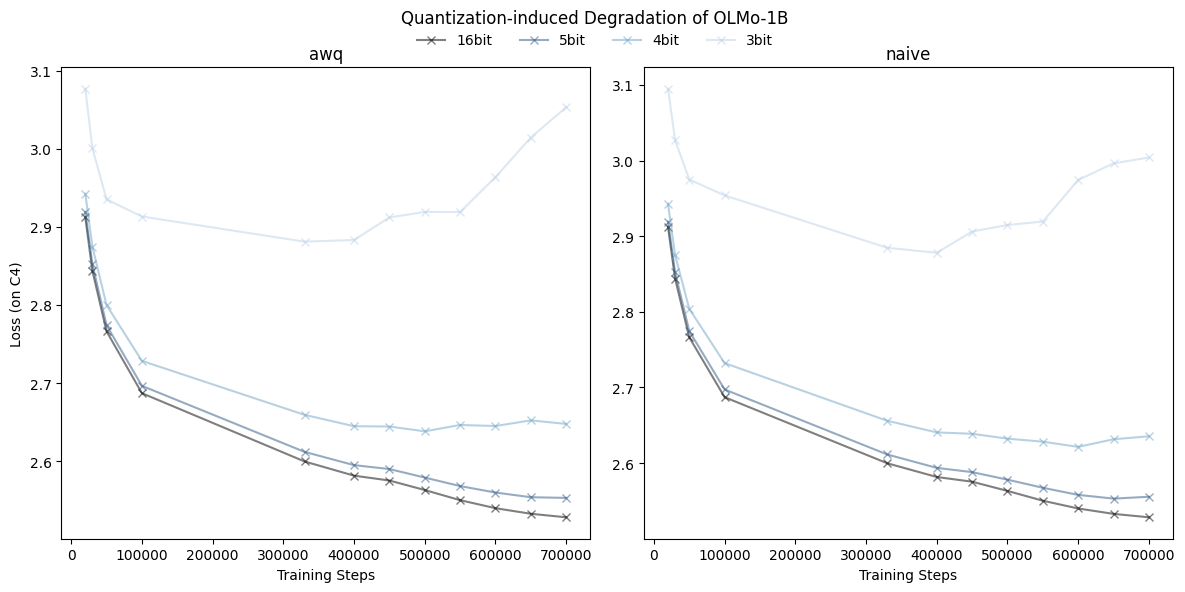

In [25]:


steps = step_to_revision['allenai/OLMo-1B'].keys()

my_loss = {'1b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}
han_loss = {'1b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}
piqa_acc = {'1b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}
wino_acc = {'1b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}
lamb_acc = {'1b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}

real_steps = []

bit_to_color = {
    "16": 'k',
    "3": '#bcd2e8',
    "4": '#73a5c6',
    "5": '#2e5984',
}



for step in steps:
    for method in ['awq', 'naive']:
        # check if step is in
        # print(path)
        path = f'results/1b,{step},{method}.json' 
        if os.path.exists(path):
            if method == 'awq': real_steps.append(int(step))
            with open(path, 'r') as file:
                result = json.load(file)
                for bits in ["16","5","4","3","2"]:
                    my_loss['1b'][method][bits].append(result[bits]['my_loss'])
                    han_loss['1b'][method][bits].append(result[bits]['han_loss'])
                    piqa_acc['1b'][method][bits].append(result[bits]['piqa,acc'])
                    wino_acc['1b'][method][bits].append(result[bits]['winogrande,acc'])
                    lamb_acc['1b'][method][bits].append(result[bits]['lambada_openai,acc'])

# print(my_loss)

fig, axes = plt.subplots(1,2,figsize=(12,6))


for i, method in enumerate(['awq', 'naive']): #
    for bits in ["16","5","4","3"]: # "2"

        axes[i].plot(real_steps, my_loss['1b'][method][bits], marker='x', label=f'{bits}bit', alpha=0.5, c=bit_to_color[bits])
    axes[i].set_title(method)
    if i == 0: pass

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc="upper center", ncol=4,bbox_to_anchor=(0.5, 0.96), frameon=False)
# axes.set_ylim(top=3.6)

fig.suptitle("Quantization-induced Degradation of OLMo-1B")
axes[0].set_ylabel("Loss (on C4)")
axes[0].set_xlabel("Training Steps")
axes[1].set_xlabel("Training Steps")
plt.tight_layout()
plt.savefig('blog/images/QiD_loss.png', bbox_inches = 'tight', dpi=200)
        

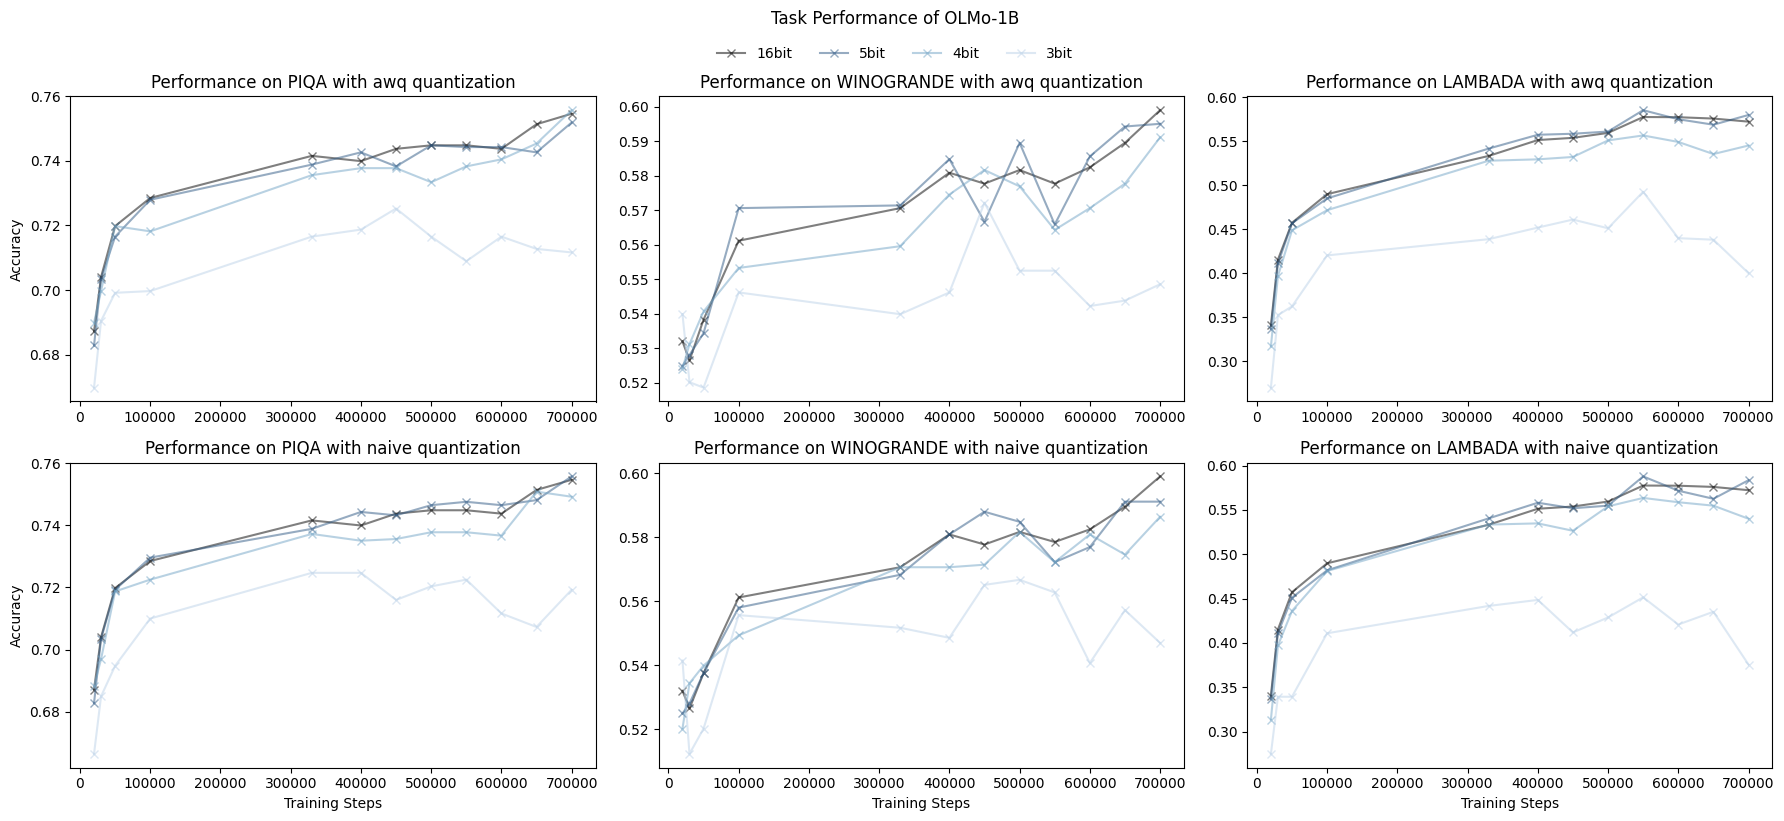

In [26]:
fig, axes = plt.subplots(2,3,figsize=(18,8))




for i, task in enumerate([piqa_acc, wino_acc, lamb_acc]):
    for j, method in enumerate(['awq', 'naive']): #
        for bits in ["16","5","4","3"]: # "2"

            axes[j,i].plot(real_steps, task['1b'][method][bits], marker='x', label=f'{bits}bit', alpha=0.5, c=bit_to_color[bits])
        if i == 0: pass

        if i == 0: task_name = 'piqa'
        if i == 1: task_name = 'winogrande'
        if i == 2: task_name = 'lambada'
        axes[j,i].set_title(f'Performance on {task_name.upper()} with {method} quantization')


handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc="upper center", ncol=4, bbox_to_anchor=(0.5, 0.99), frameon=False)
fig.suptitle("Task Performance of OLMo-1B", y=1.02)

axes[1,0].set_xlabel('Training Steps')
axes[1,1].set_xlabel('Training Steps')
axes[1,2].set_xlabel('Training Steps')

axes[0,0].set_ylabel('Accuracy')
axes[1,0].set_ylabel('Accuracy')
plt.tight_layout()
plt.savefig('blog/images/QiD_task_perf.png', bbox_inches = 'tight', dpi=200)


In [27]:
# statistics here


stats = {}

real_steps = []
for step in steps:
        stats[step] = {}
        # check if step is in
        # print(path)
        path = f'statistics/1b,{step}.json'
        print(path) 
        if os.path.exists(path):
            real_steps.append(int(step))
            with open(path, 'r') as file:
                result = json.load(file)
                # for bits in ["16","5","4","3","2"]:
                    
                    # comes up w all the param names
                sum_abs_max = 0
                sum_abs_mean = 0
                num_greater_than_1 = 0
                num_greater_than_10 = 0
                num_greater_than_100 = 0
                num = 0
                for layer in range(16):
                    for param in ['att_proj', 'attn_out', 'ff_proj', 'ff_out']:
                        for loc in ['in', 'out']:
                            param_name = f'model.transformer.blocks.{layer}.{param},{loc}'
                            sum_abs_max += result[param_name]['abs_max']
                            sum_abs_mean += result[param_name]['abs_mean']
                            num_greater_than_1 += result[param_name][">1"]
                            num_greater_than_10 += result[param_name][">10"]
                            num_greater_than_100 += result[param_name][">100"]

                            num +=1
                # print(sum_abs_max/num)
                # print(sum_abs_mean/num)
                # print(num_greater_than_10)
                stats[step] = {
                     'avg_abs_max': sum_abs_max/num,
                     'avg_abs_mean': sum_abs_mean/num,
                     'num_greater_than_1': num_greater_than_1,
                     'num_greater_than_10': num_greater_than_10,
                     'num_greater_than_100': num_greater_than_100,
                }
        # print('---')
print(stats)

statistics/1b,20000.json
statistics/1b,30000.json
statistics/1b,40000.json
statistics/1b,50000.json
statistics/1b,100000.json
statistics/1b,330000.json
statistics/1b,400000.json
statistics/1b,450000.json
statistics/1b,500000.json
statistics/1b,550000.json
statistics/1b,600000.json
statistics/1b,650000.json
statistics/1b,700000.json
{'20000': {'avg_abs_max': 26.18172185565345, 'avg_abs_mean': 0.43235349477618, 'num_greater_than_1': 22144005, 'num_greater_than_10': 6428, 'num_greater_than_100': 6}, '30000': {'avg_abs_max': 32.220510717481375, 'avg_abs_mean': 0.40156143353669904, 'num_greater_than_1': 18632785, 'num_greater_than_10': 2303, 'num_greater_than_100': 10}, '40000': {}, '50000': {'avg_abs_max': 32.087901674211025, 'avg_abs_mean': 0.38635829379200004, 'num_greater_than_1': 16794030, 'num_greater_than_10': 3136, 'num_greater_than_100': 11}, '100000': {'avg_abs_max': 38.71518182940781, 'avg_abs_mean': 0.38251595504698344, 'num_greater_than_1': 16157459, 'num_greater_than_10': 2796

[20000, 30000, 50000, 100000, 330000, 400000, 450000, 500000, 550000, 600000, 650000, 700000]


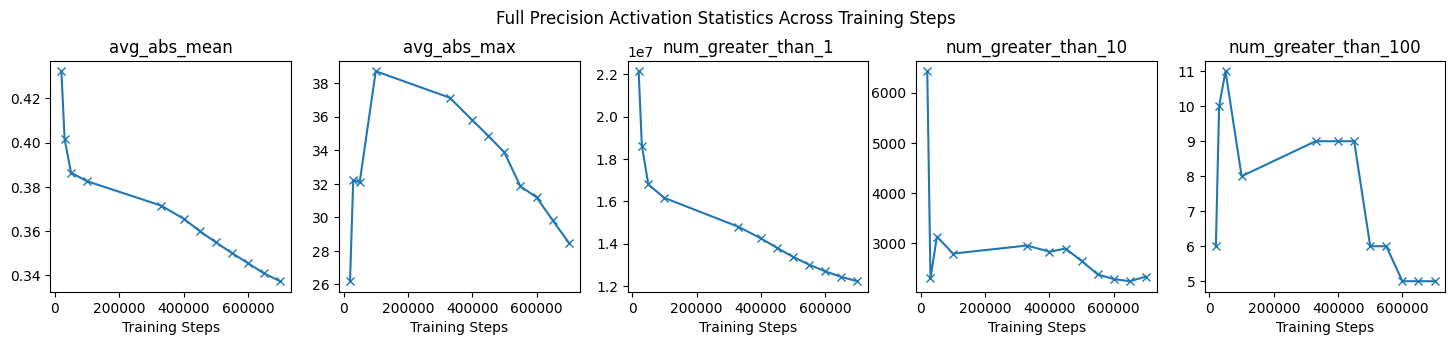

In [28]:
# get avg of each?
# and plot wrt to 

fig, axes = plt.subplots(1,5, figsize=(18,3))

axes[0].plot(real_steps, [stats[str(step)]['avg_abs_mean'] for step in real_steps], marker='x')
axes[0].set_title('avg_abs_mean')
axes[1].plot(real_steps, [stats[str(step)]['avg_abs_max'] for step in real_steps], marker='x')
axes[1].set_title('avg_abs_max')
axes[2].plot(real_steps, [stats[str(step)]['num_greater_than_1'] for step in real_steps], marker='x')
axes[2].set_title('num_greater_than_1')
axes[3].plot(real_steps, [stats[str(step)]['num_greater_than_10'] for step in real_steps], marker='x')
axes[3].set_title('num_greater_than_10')
axes[4].plot(real_steps, [stats[str(step)]['num_greater_than_100'] for step in real_steps], marker='x')
axes[4].set_title('num_greater_than_100')

axes[0].set_xlabel('Training Steps')
axes[1].set_xlabel('Training Steps')
axes[2].set_xlabel('Training Steps')
axes[3].set_xlabel('Training Steps')
axes[4].set_xlabel('Training Steps')
fig.suptitle('Full Precision Activation Statistics Across Training Steps', y=1.05)
print(real_steps)

plt.savefig('blog/images/16bit_statistics.png', bbox_inches = 'tight', dpi=200)

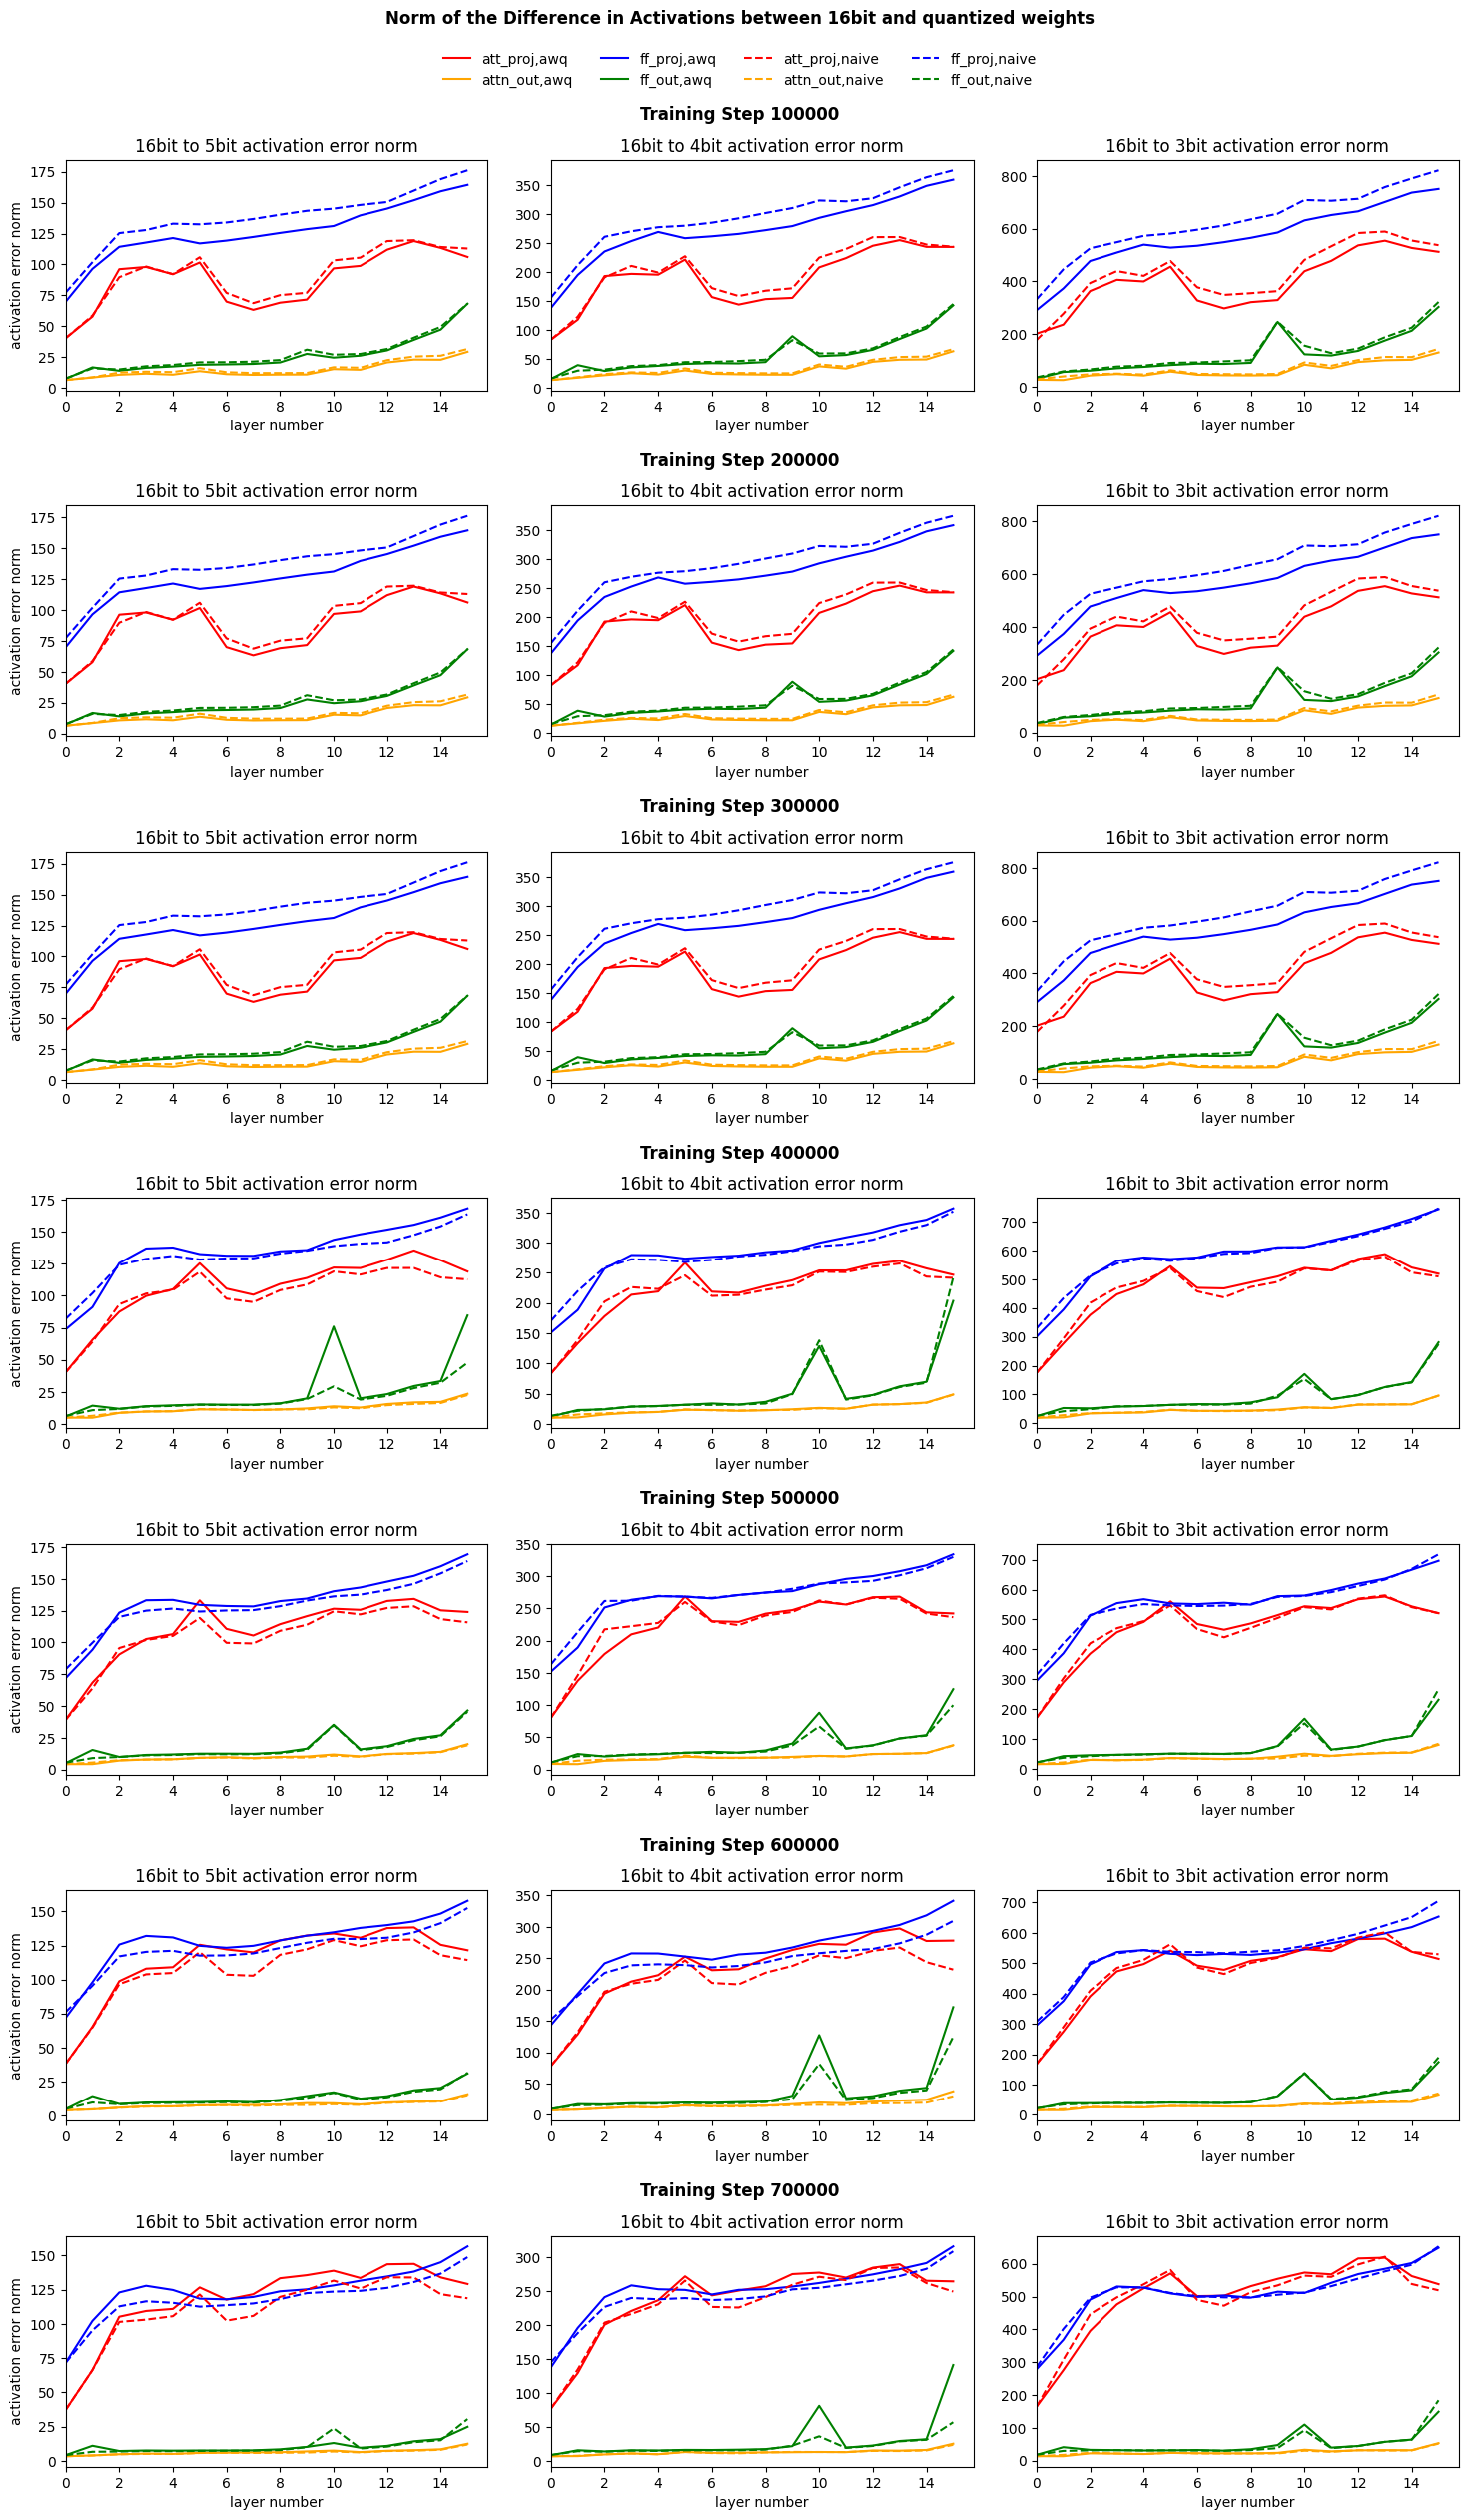

In [29]:
# error here


# append the results here.

param_to_color = {
    'att_proj': 'red',
    'attn_out': 'orange',
    'ff_proj': 'blue',
    'ff_out': 'green'
}

quant_to_line = {
    'awq': '-',
    'naive': '--'
}

error_norm = {'awq': {'5': {}, '4': {}, '3': {}, '2': {}}, 'naive': {'5': {}, '4': {}, '3': {}, '2': {}}}
error_max_diff = {'awq': {'5': {}, '4': {}, '3': {}, '2': {}}, 'naive': {'5': {}, '4': {}, '3': {}, '2': {}}}

fig, axes = plt.subplots(7,3,figsize=(18,30))

steps = ['100000', '200000', '300000', '400000','500000','600000','700000']
for s, step in enumerate(steps):
    for method in ['awq', 'naive']:
        # check if step is in
        # print(path)
        path = f'errors/1b,{step},{method}.json' 
        if os.path.exists(path):
            if method == 'awq': real_steps.append(int(step))
            with open(path, 'r') as file:
                result = json.load(file)
                for bits in ["5","4","3","2"]:
                    
                    # comes up w all the param names
                
                    for param in ['att_proj', 'attn_out', 'ff_proj', 'ff_out']:
                    # for param in ['attn_out']:
                        error_norm[method][bits][param] = []
                        error_max_diff[method][bits][param] = []
                        for layer in range(16):
                            for loc in ['out']:
                                name = f'model.transformer.blocks.{layer}.{param},{loc}'
                                # print(result[bits].keys())
                                error_norm[method][bits][param].append(result[bits][name]['error_norm'])
                                error_max_diff[method][bits][param].append(result[bits][name]['error_max_diff'])
        for j, param in enumerate(['att_proj', 'attn_out', 'ff_proj', 'ff_out']):
            for i, bits in enumerate(["5", "4", "3"]): # "5","4","3","2"
                x = [i for i in range(len(error_norm[method][bits][param]))]
                axes[s, i].plot(x, error_norm[method][bits][param], label=f'{param},{method}', c=param_to_color[param], linestyle=quant_to_line[method])
                axes[s, i].set_xlim(left=0)
                axes[s, i].set_title(f'16bit to {bits}bit activation error norm')
                axes[s, i].set_xlabel('layer number')
                if i==0: axes[s,i].set_ylabel('activation error norm')

                # axes[s, i].legend()
# print(error_norm)

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc="upper center", ncol=4, bbox_to_anchor=(0.5, 0.92), frameon=False)
plt.subplots_adjust(wspace=0.15, hspace=0.5)

for k, step in enumerate(steps):
    fig.text(0.5, axes[k, 0].get_position().y1+0.015, f'Training Step {step}', ha='center', va='center', fontsize=12, weight='bold')

fig.suptitle('Norm of the Difference in Activations between 16bit and quantized weights', weight='bold', y=0.93)

plt.savefig('blog/images/error_norm.png', bbox_inches = 'tight', dpi=200)


In [30]:
# for method in ['awq', 'naive']:
#     for j, param in enumerate(['att_proj', 'attn_out', 'ff_proj', 'ff_out']):
#         for i, bits in enumerate(["5", "4", "3"]): # "5","4","3","2"
#             x = [i for i in range(len(error_norm[method][bits][param]))]
#             axes[i].plot(x, error_norm[method][bits][param], label=f'{param},{method},{bits}')
#             axes[i].set_xlim(left=0)

#             axes[i].legend()

### 7B plots:

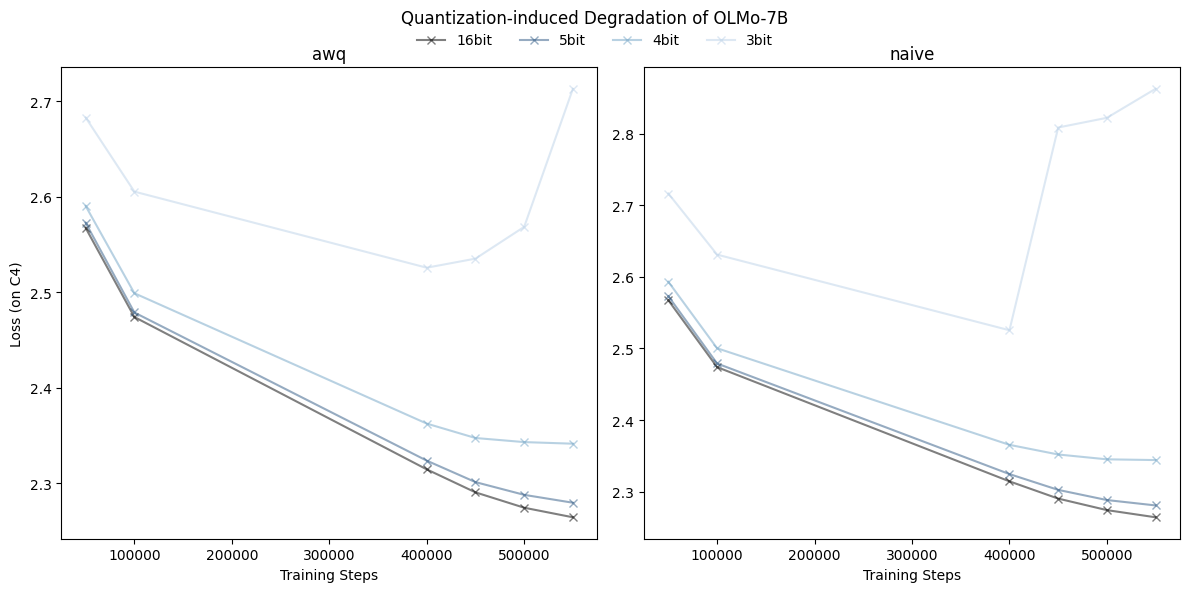

In [31]:


steps = step_to_revision['allenai/OLMo-1B'].keys()

my_loss = {'7b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}
han_loss = {'7b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}
piqa_acc = {'7b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}
wino_acc = {'7b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}
lamb_acc = {'7b': {'awq': {"16":[],"5":[],"4":[],"3":[],"2":[]}, 'naive': {"16":[],"5":[],"4":[],"3":[],"2":[]}}}

real_steps = []

bit_to_color = {
    "16": 'k',
    "3": '#bcd2e8',
    "4": '#73a5c6',
    "5": '#2e5984',
}



for step in steps:
    for method in ['awq', 'naive']:
        # check if step is in
        # print(path)
        path = f'results/7b,{step},{method}.json' 
        if os.path.exists(path):
            if method == 'awq': real_steps.append(int(step))
            with open(path, 'r') as file:
                result = json.load(file)
                for bits in ["16","5","4","3","2"]:
                    my_loss['7b'][method][bits].append(result[bits]['my_loss'])
                    han_loss['7b'][method][bits].append(result[bits]['han_loss'])
                    piqa_acc['7b'][method][bits].append(result[bits]['piqa,acc'])
                    wino_acc['7b'][method][bits].append(result[bits]['winogrande,acc'])
                    lamb_acc['7b'][method][bits].append(result[bits]['lambada_openai,acc'])

# print(my_loss)

fig, axes = plt.subplots(1,2,figsize=(12,6))


for i, method in enumerate(['awq', 'naive']): #
    for bits in ["16","5","4","3"]: # "2"

        axes[i].plot(real_steps, my_loss['7b'][method][bits], marker='x', label=f'{bits}bit', alpha=0.5, c=bit_to_color[bits])
    axes[i].set_title(method)
    if i == 0: pass

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc="upper center", ncol=4,bbox_to_anchor=(0.5, 0.96), frameon=False)
# axes.set_ylim(top=3.6)

fig.suptitle("Quantization-induced Degradation of OLMo-7B")
axes[0].set_ylabel("Loss (on C4)")
axes[0].set_xlabel("Training Steps")
axes[1].set_xlabel("Training Steps")
plt.tight_layout()
plt.savefig('blog/images/QiD_loss_7B.png', bbox_inches = 'tight', dpi=200)

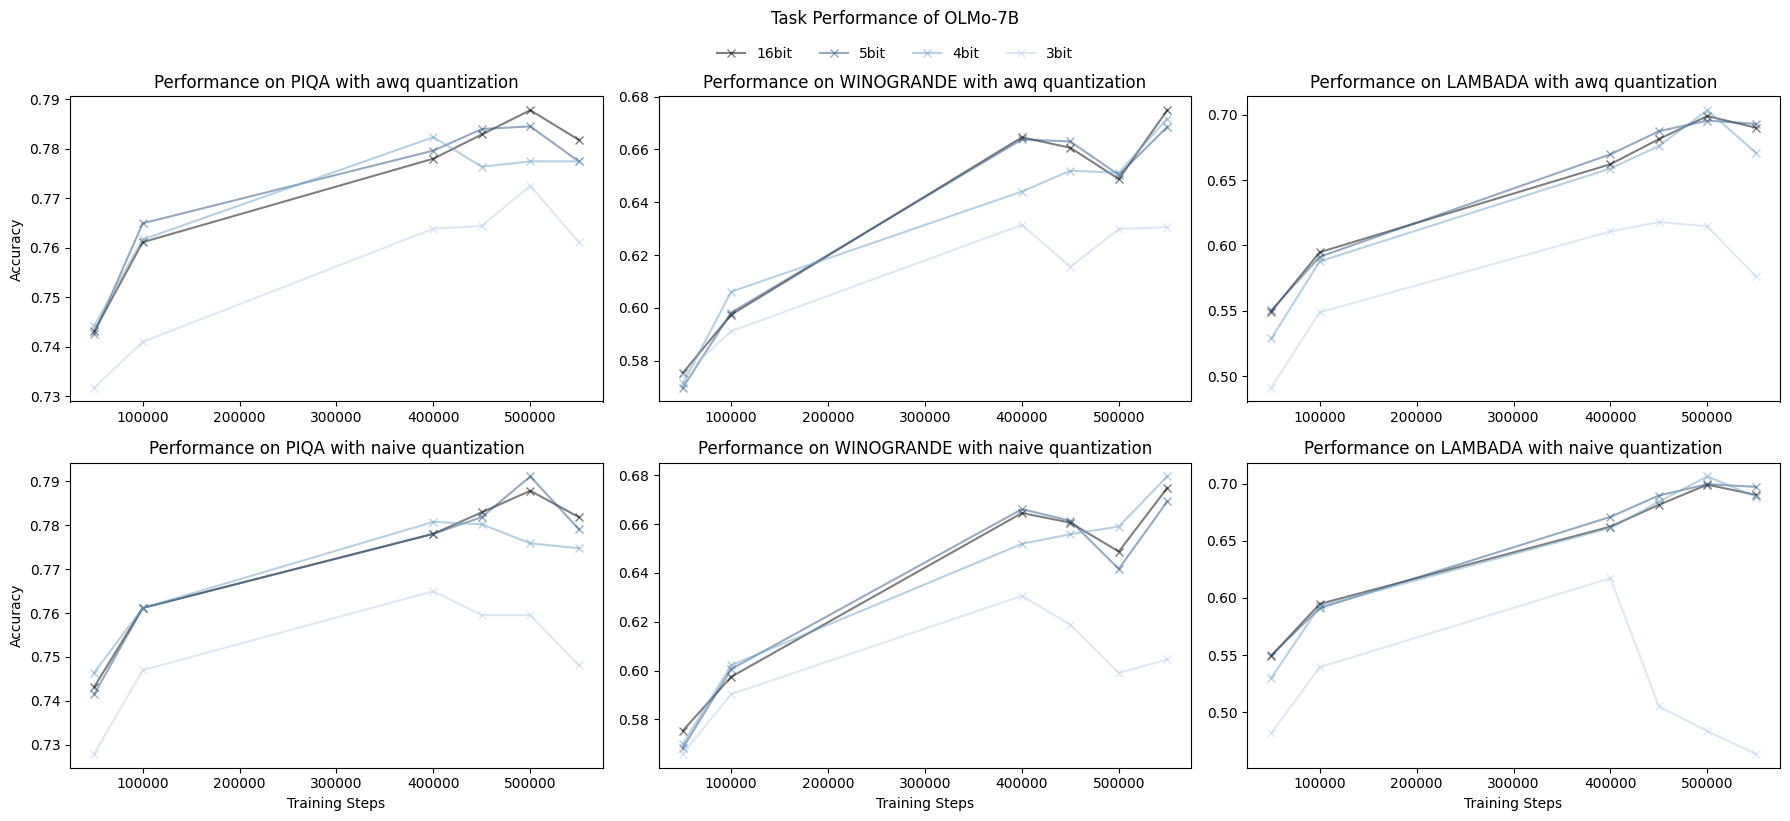

In [32]:
fig, axes = plt.subplots(2,3,figsize=(18,8))




for i, task in enumerate([piqa_acc, wino_acc, lamb_acc]):
    for j, method in enumerate(['awq', 'naive']): #
        for bits in ["16","5","4","3"]: # "2"

            axes[j,i].plot(real_steps, task['7b'][method][bits], marker='x', label=f'{bits}bit', alpha=0.5, c=bit_to_color[bits])
        if i == 0: pass

        if i == 0: task_name = 'piqa'
        if i == 1: task_name = 'winogrande'
        if i == 2: task_name = 'lambada'
        axes[j,i].set_title(f'Performance on {task_name.upper()} with {method} quantization')


handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc="upper center", ncol=4, bbox_to_anchor=(0.5, 0.99), frameon=False)
fig.suptitle("Task Performance of OLMo-7B", y=1.02)

axes[1,0].set_xlabel('Training Steps')
axes[1,1].set_xlabel('Training Steps')
axes[1,2].set_xlabel('Training Steps')

axes[0,0].set_ylabel('Accuracy')
axes[1,0].set_ylabel('Accuracy')
plt.tight_layout()
plt.savefig('blog/images/QiD_task_perf_7B.png', bbox_inches = 'tight', dpi=200)

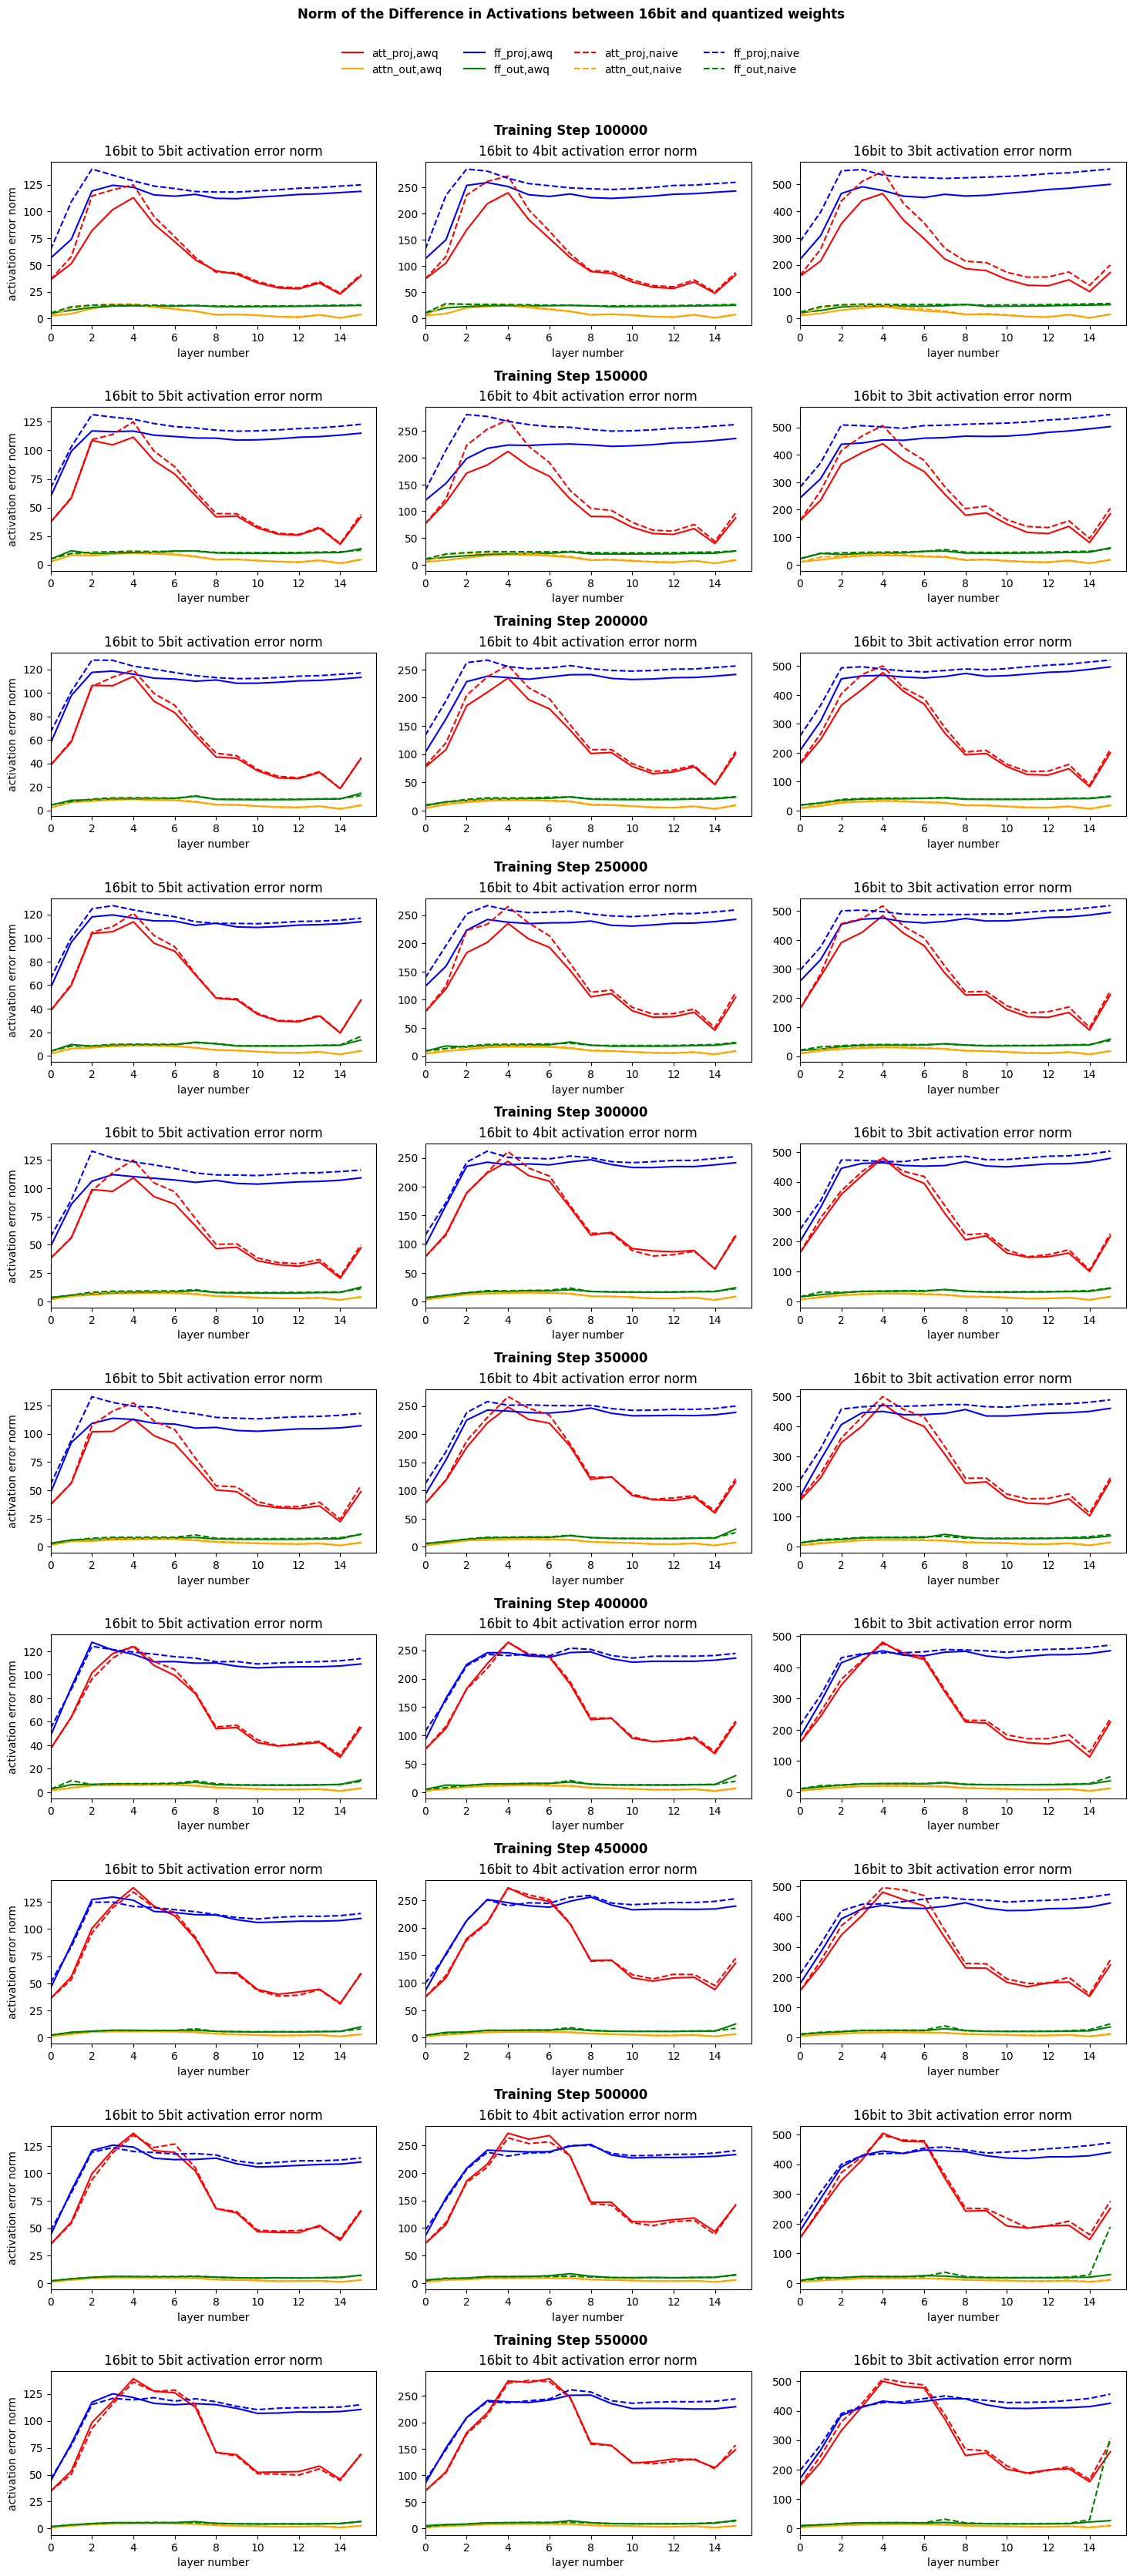

In [ ]:
# error here


# append the results here.

param_to_color = {
    'att_proj': 'red',
    'attn_out': 'orange',
    'ff_proj': 'blue',
    'ff_out': 'green'
}

quant_to_line = {
    'awq': '-',
    'naive': '--'
}

error_norm = {'awq': {'5': {}, '4': {}, '3': {}, '2': {}}, 'naive': {'5': {}, '4': {}, '3': {}, '2': {}}}
error_max_diff = {'awq': {'5': {}, '4': {}, '3': {}, '2': {}}, 'naive': {'5': {}, '4': {}, '3': {}, '2': {}}}

fig, axes = plt.subplots(10,3,figsize=(18,40))

steps = ['100000', '150000', '200000', '250000', '300000', '350000', '400000', '450000', '500000', '550000']
for s, step in enumerate(steps):
    for method in ['awq', 'naive']:
        # check if step is in
        # print(path)
        path = f'errors/7b,{step},{method}.json' 
        if os.path.exists(path):
            if method == 'awq': real_steps.append(int(step))
            with open(path, 'r') as file:
                result = json.load(file)
                for bits in ["5","4","3"]:
                    
                    # comes up w all the param names
                
                    for param in ['att_proj', 'attn_out', 'ff_proj', 'ff_out']:
                    # for param in ['attn_out']:
                        error_norm[method][bits][param] = []
                        error_max_diff[method][bits][param] = []
                        for layer in range(16):
                            for loc in ['out']:
                                name = f'model.transformer.blocks.{layer}.{param},{loc}'
                                # print(result[bits].keys())
                                error_norm[method][bits][param].append(result[bits][name]['error_norm'])
                                error_max_diff[method][bits][param].append(result[bits][name]['error_max_diff'])
        for j, param in enumerate(['att_proj', 'attn_out', 'ff_proj', 'ff_out']):
            for i, bits in enumerate(["5", "4", "3"]): # "5","4","3","2"
                x = [i for i in range(len(error_norm[method][bits][param]))]
                axes[s, i].plot(x, error_norm[method][bits][param], label=f'{param},{method}', c=param_to_color[param], linestyle=quant_to_line[method])
                axes[s, i].set_xlim(left=0)
                axes[s, i].set_title(f'16bit to {bits}bit activation error norm')
                axes[s, i].set_xlabel('layer number')
                if i==0: axes[s,i].set_ylabel('activation error norm')

                # axes[s, i].legend()
# print(error_norm)

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc="upper center", ncol=4, bbox_to_anchor=(0.5, 0.92), frameon=False)
plt.subplots_adjust(wspace=0.15, hspace=0.5)

for k, step in enumerate(steps):
    fig.text(0.5, axes[k, 0].get_position().y1+0.01, f'Training Step {step}', ha='center', va='center', fontsize=12, weight='bold')

fig.suptitle('Norm of the Difference in Activations between 16bit and quantized weights', weight='bold', y=0.93)

plt.savefig('blog/images/error_norm_7B.png', bbox_inches = 'tight', dpi=200)